In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import seaborn as sns
import matplotlib.patches as patches
import anndata as ad
import scanpy as sc

import cellspec as spc

%matplotlib inline

# DNA and RNA read counts:

In [5]:
def ordmag_algorithm(df, expected_cells=None):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # Function to compute OrdMag(x)
    def ordmag(x):
        # Calculate the 99th percentile of the top x readcounts
        m = df['read_count'].iloc[:int(x)].quantile(0.99)
        # Count barcodes with readcounts >= m / 10
        return (df['read_count'] >= m / 10).sum()

    if expected_cells is None:
        # Loss function for optimization
        def loss_function(x):
            ordmag_x = ordmag(x)
            return ((ordmag_x - x) ** 2) / x

        # Minimize the loss function to find the optimal number of barcodes
        result = minimize(loss_function, x0=len(df)//2, bounds=[(1, len(df))])
        expected_cells = int(result.x[0])

    # Calculate the threshold using the expected or estimated number of cells
    m = df['read_count'].iloc[:expected_cells].quantile(0.99)
    threshold = m / 10

    # Identify barcodes that are considered cells (readcounts >= threshold)
    cell_barcodes = df[df['read_count'] >= threshold]['barcode'].values

    return cell_barcodes, expected_cells


In [39]:
dna_read_counts = pd.read_csv('../bin/PolE_worm_pilot/readcounts_dna.csv', index_col='barcode')
rna_read_counts = pd.read_csv('../bin/PolE_worm_pilot/readcounts_rna.csv', index_col='barcode')
shared = list(set(dna_read_counts.index).intersection(set(rna_read_counts.index)))
read_counts = pd.DataFrame(index=shared, data={'RNA read counts':rna_read_counts.loc[shared]['read_count'], 'DNA read counts':dna_read_counts.loc[shared]['read_count']})
read_counts

,RNA read counts,DNA read counts
GGTCATTGAGGAGATACCGAACTCAGAATGCCAAGGGGCATCAAA,4,1108
AAGGCTTGAGGACGACATTCACTCCGCCAATAAAGGCGGTTGATA,282,32066
TATCAGCCAGGAACCTTCAGACTCACAGTAGCAAGGTTGACCACA,2,16
TATCCGGTAGGACACCTTGAACTCTATGCGACAAGGGATGGTCTA,4,54
AAGGCTTGAGGAAGATGGTCACTCGCAATGACAAGGACATCGTCA,3,809
...,...,...
GTAATGCCAGGACGACATTCACTCTAACGGAGAAGGCGGTAAGTA,7,287
GTGGTGATAGGACTGCTCAAACTCCATCGTTGAAGGTTCCACTCA,64,3574
CAACCAACAGGAAAGGTGACACTCAGGTCGTAAAGGCGGTAAGTA,13,409
ACTAACCGAGGAAGGCTAACACTCACAGTAGCAAGGGACAGCATA,2,410


In [53]:
real_cells = pd.read_csv('../bin/PolE_worm_pilot/real_cells.txt',index_col=0, header=None, names=['barcode'])
read_counts['prediction'] = ['real cell' if bc in real_cells.index.to_list() else 'empty capsule' for bc in read_counts.index.to_list()]
read_counts

,RNA read counts,DNA read counts,prediction
GGTCATTGAGGAGATACCGAACTCAGAATGCCAAGGGGCATCAAA,4,1108,empty capsule
AAGGCTTGAGGACGACATTCACTCCGCCAATAAAGGCGGTTGATA,282,32066,empty capsule
TATCAGCCAGGAACCTTCAGACTCACAGTAGCAAGGTTGACCACA,2,16,empty capsule
TATCCGGTAGGACACCTTGAACTCTATGCGACAAGGGATGGTCTA,4,54,empty capsule
AAGGCTTGAGGAAGATGGTCACTCGCAATGACAAGGACATCGTCA,3,809,empty capsule
...,...,...,...
GTAATGCCAGGACGACATTCACTCTAACGGAGAAGGCGGTAAGTA,7,287,empty capsule
GTGGTGATAGGACTGCTCAAACTCCATCGTTGAAGGTTCCACTCA,64,3574,empty capsule
CAACCAACAGGAAAGGTGACACTCAGGTCGTAAAGGCGGTAAGTA,13,409,empty capsule
ACTAACCGAGGAAGGCTAACACTCACAGTAGCAAGGGACAGCATA,2,410,empty capsule


Text(0, 0.5, 'Reads with splice junctions')

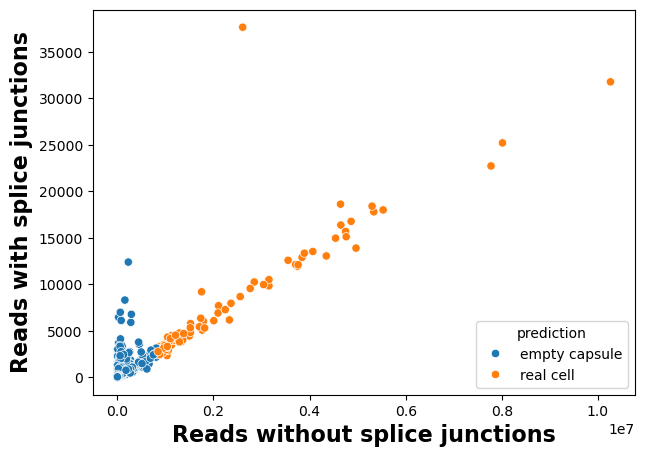

In [57]:
f, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=read_counts, x='DNA read counts', y='RNA read counts',
                hue='prediction',
                ax=ax,
               )
# ax.set_yscale('log')
plt.xlabel("Reads without splice junctions", fontweight='bold', fontsize=16)
plt.ylabel("Reads with splice junctions", fontweight='bold', fontsize=16)

Text(0, 0.5, 'Reads with splice junctions')

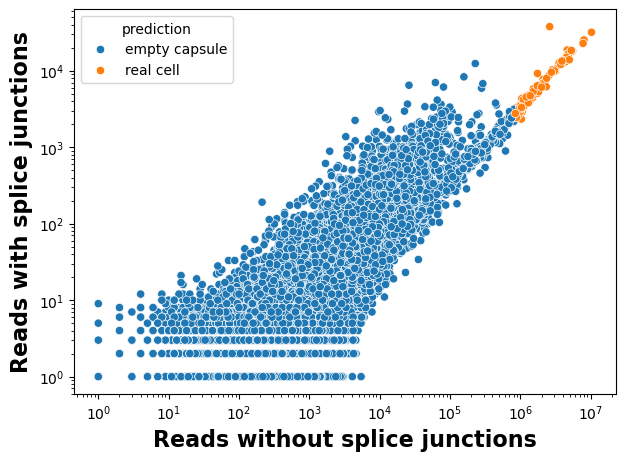

In [59]:
f, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=read_counts, x='DNA read counts', y='RNA read counts',
                hue='prediction',
                ax=ax,
               )
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Reads without splice junctions", fontweight='bold', fontsize=16)
plt.ylabel("Reads with splice junctions", fontweight='bold', fontsize=16)

In [56]:
read_counts.loc[real_cells.index]['RNA read counts'].mean()

np.float64(8186.1325301204815)

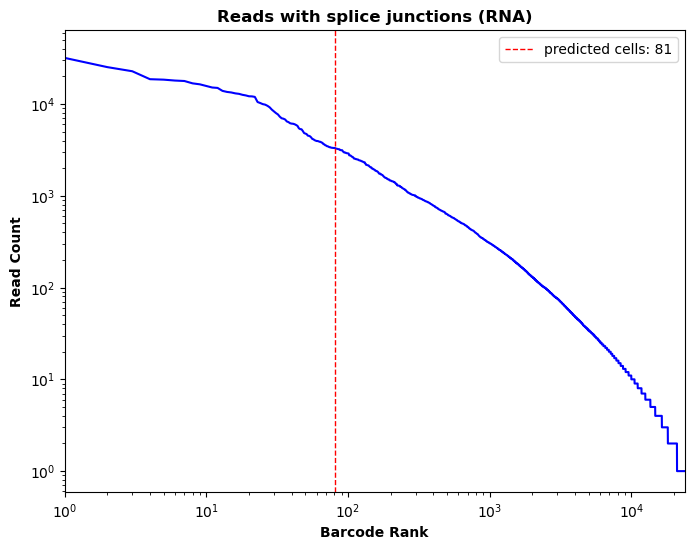

In [28]:
rna_read_counts = pd.read_csv('../bin/PolE_worm_pilot/readcounts_rna.csv')

# Ensure data is sorted by read_count in descending order
read_counts = rna_read_counts.sort_values(by='read_count', ascending=False)

cell_barcodes, optimal_cells = ordmag_algorithm(read_counts)

plt.figure(figsize=(8, 6))
plt.plot(read_counts['barcode'].to_numpy(), read_counts['read_count'].to_numpy(), linestyle='-', color='blue')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,len(read_counts['barcode']))
plt.axvline(x=optimal_cells, color='red', label=f'predicted cells: {optimal_cells}', linestyle='--', linewidth=1)
plt.xlabel('Barcode Rank', fontdict={'weight':'bold'})
plt.ylabel('Read Count', fontdict={'weight':'bold'})
plt.title("Reads with splice junctions (RNA)", fontdict={'weight':'bold'})
plt.legend()

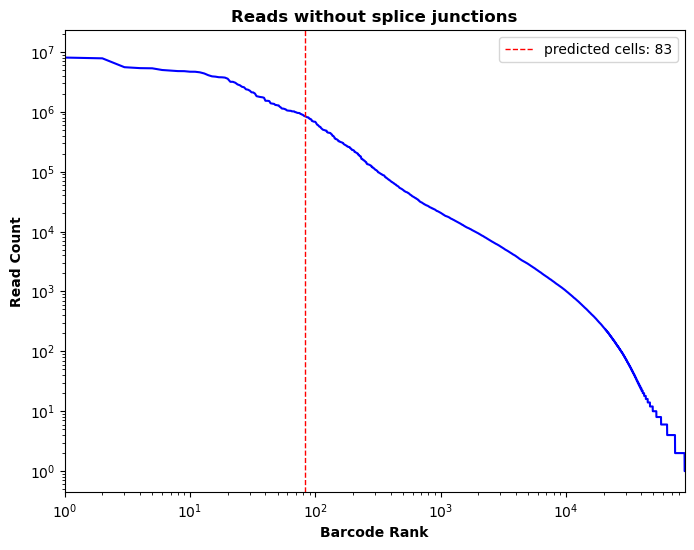

In [12]:
dna_read_counts = pd.read_csv('../bin/PolE_worm_pilot/readcounts_dna.csv')

# Ensure data is sorted by read_count in descending order
read_counts = dna_read_counts.sort_values(by='read_count', ascending=False)

cell_barcodes, optimal_cells = ordmag_algorithm(read_counts)

plt.figure(figsize=(8, 6))
plt.plot(read_counts['barcode'].to_numpy(), read_counts['read_count'].to_numpy(), linestyle='-', color='blue')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,len(read_counts['barcode']))
plt.axvline(x=optimal_cells, color='red', label=f'predicted cells: {optimal_cells}', linestyle='--', linewidth=1)
plt.xlabel('Barcode Rank', fontdict={'weight':'bold'})
plt.ylabel('Read Count', fontdict={'weight':'bold'})
plt.title("Reads without splice junctions", fontdict={'weight':'bold'})
plt.legend()

# RNA analysis

In [46]:
csvs = {
    'UDI_5':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_6':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_7':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
    'UDI_8':'../results/worm_CapGTA_UDI_5/rna_counts_matrix.csv',
}

adatas = []

for batch_id,csv in csvs.items():
    df = pd.read_csv(csv, index_col=0)

    # AnnData expects cells x genes, so transpose
    adata = ad.AnnData(X=df.T.values)
    adata.obs_names = [f"{bc}_{batch_id}" for bc in df.columns]   # cell barcodes
    adata.var_names = df.index.tolist()
    adata.obs['UDI'] = batch_id

    adatas.append(adata)
    
rna_ad = ad.concat(adatas)
rna_ad

AnnData object with n_obs × n_vars = 4000 × 46748
    obs: 'UDI'

Text(0, 0.5, 'Cells')

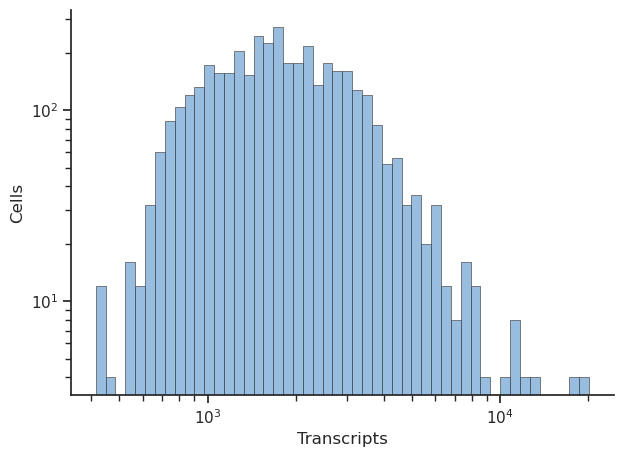

In [47]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(rna_ad.X.sum(axis=1), 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             log_scale=True,
             bins=50
            )
ax.set_yscale('log')
plt.xlabel("Transcripts", fontsize=12)
plt.ylabel("Cells", fontsize=12)


In [48]:
rna_ad.X.sum(axis=1).mean()

np.float64(2141.739)

In [49]:
# Saving count data
rna_ad.layers["counts"] = rna_ad.X.copy()

In [50]:
# Normalizing to median total counts
sc.pp.normalize_total(rna_ad)
# Logarithmize the data
sc.pp.log1p(rna_ad)

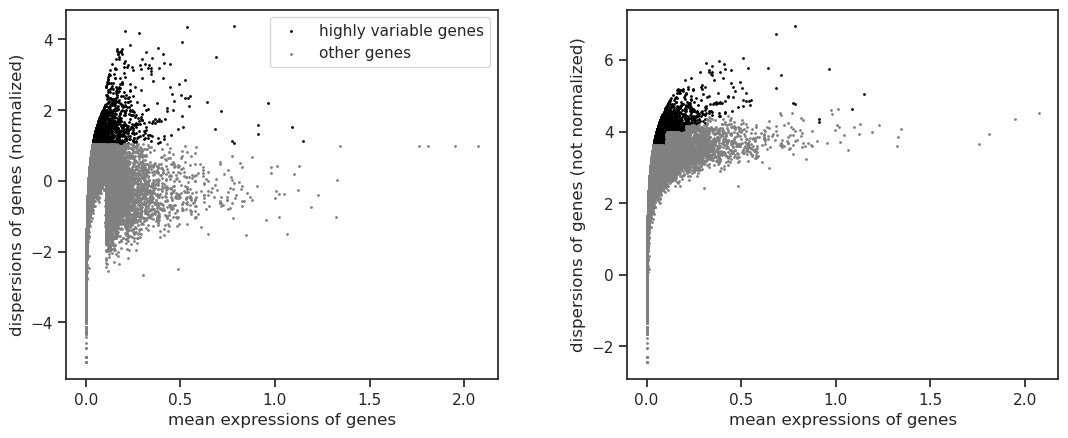

In [51]:
sc.pp.highly_variable_genes(rna_ad, n_top_genes=2000)
sc.pl.highly_variable_genes(rna_ad)


In [52]:
sc.pp.highly_variable_genes(rna_ad, n_top_genes=2000, subset=True)

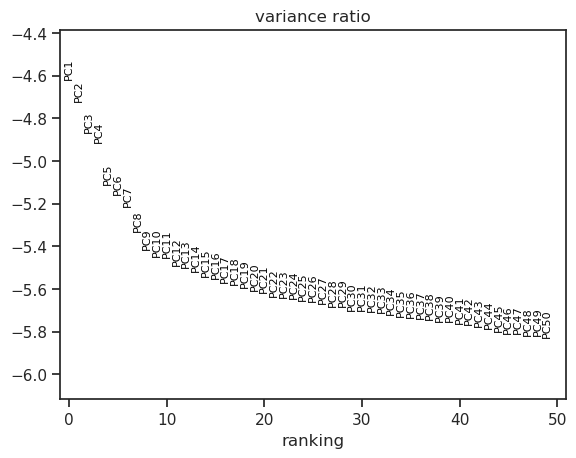

In [53]:
sc.tl.pca(rna_ad)
sc.pl.pca_variance_ratio(rna_ad, n_pcs=50, log=True)

In [54]:
sc.pp.neighbors(rna_ad)
sc.tl.umap(rna_ad)

In [55]:
sc.tl.leiden(rna_ad)

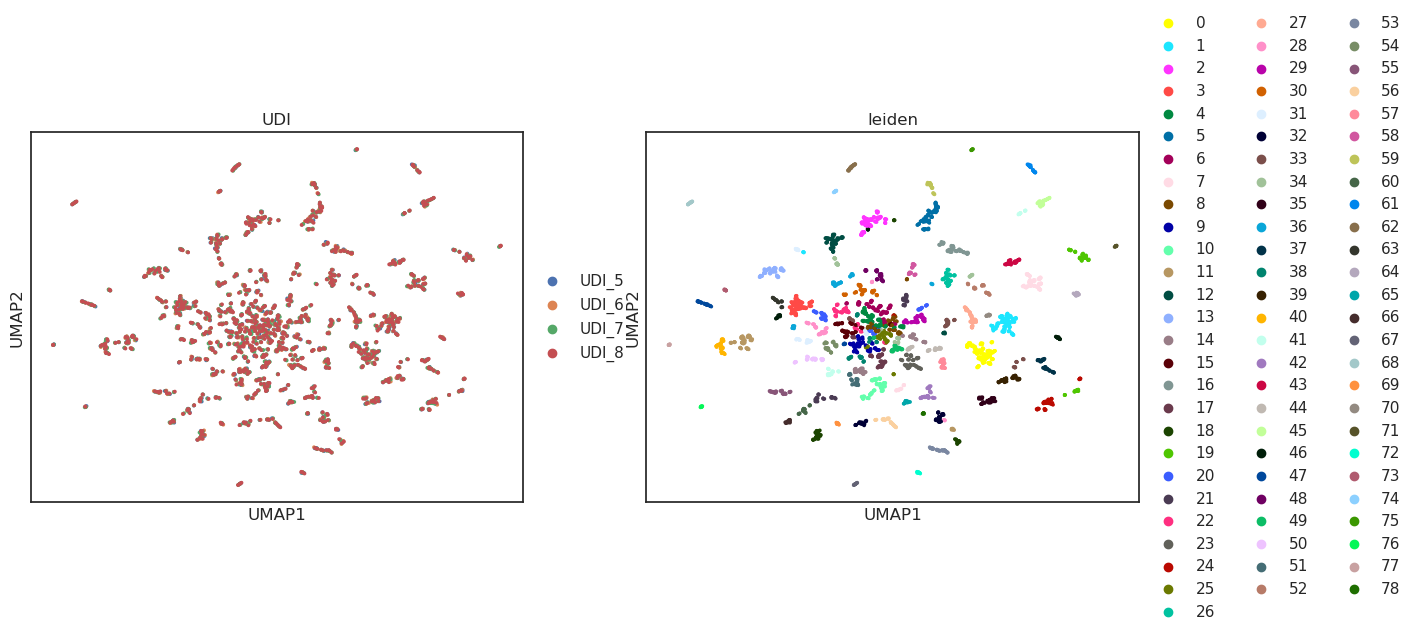

In [56]:
sc.pl.umap(
    rna_ad,
    color=['UDI','leiden']
)

### Integration with WormSeq atlas